# Temporal Fusion Transformer
Past-covariates:
- open
- high
- low
- volume

Future-covariates:
- hour
- minute

[Note on vscode jupyter notebook and nbconvert](https://jupyter-format.readthedocs.io/en/latest/nbconvert.html) <br>
[omg what a lifesaver...](https://www.pythonfixing.com/2021/12/fixed-notebook-validation-failed-jupyter.html)

In [1]:
EPOCHS = 1
# Rule of thumb: 10-20% Forward v Backward
LOOKBACK = 3600 # 1hr
FORWARD = 600 # 10 mins

In [22]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
#======UEXP============
from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
from ue.uexp.dataprocessing.func import *
#======PytorchLightning===========
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.plugins import DDPPlugin
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import Callback

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
import time
from datetime import timedelta
startTime = time.time()

## Temporal Fusion Transformer (TFT)

Darts' `TFTModel` incorporates the following main components from the original Temporal Fusion Transformer (TFT) architecture as outlined in [this paper](https://arxiv.org/pdf/1912.09363.pdf):

- gating mechanisms: skip over unused components of the model architecture
- variable selection networks: select relevant input variables at each time step.
- temporal processing of past and future input with LSTMs (long short-term memory)
- multi-head attention: captures long-term temporal dependencies
- prediction intervals: per default, produces quantile forecasts instead of deterministic values

### Training
`TFTModel` can be trained with past and future covariates. It is trained sequentially on fixed-size chunks consisting of an encoder and a decoder part:

- encoder: past input with `input_chunk_length`
  - **past target**: mandatory
  - **past covariates**: optional
- decoder: future known input with `output_chunk_length`
  - **future covariates**: mandatory (if none are available, consider `TFTModel`'s optional arguments `add_encoders` or `add_relative_index` from [here](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tft_model.html?highlight=tftmodel#temporal-fusion-transformer-tft))

In each iteration, the model produces a quantile prediction of shape `(output_chunk_length, n_quantiles)` on the decoder part.

### Forecast
#### Probabilistic Forecast
Per default, `TFTModel` produces probabilistic quantile forecasts using `QuantileRegression`.
This gives the range of likely target values at each prediction step.
Most deep learning models in Darts'  - including `TFTModel` -  support `QuantileRegression` and 16 other likelihoods to produce probabilistic forecasts by setting `likelihood=MyLikelihood()` at model creation.

To produce meaningful results, set `num_samples >> 1` when predicting. For example:

```
model.predict(*args, **kwargs, num_samples=200)
```

Predictions with forecasting horizon `n` are generated auto-regressively using encoder-decoder chunks of the same size as during training.

If `n > output_chunk_length`, you have to supply additional future values for the covariates you passed to `model.train()`.

#### Deterministic Forecast
To produce deterministic rather than probabilistic forecasts, set parameter `likelihood` to `None` and `loss_fn` to a PyTorch loss function at model creation. For example:

```
model = TFTModel(*args, **kwargs, likelihood=None, loss_fn=torch.nn.MSELoss())
...
model.predict(*args, **kwargs, num_samples=1)
```

In [3]:
# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [4]:
### get data (set config params)
ticker_list = ["BTCUSDT"]
start_date = "2022-02-20"
end_date = "2022-02-21"
time_interval = "1s"

p = BinanceProcessor("binance")
df = p.download_data(ticker_list, start_date, end_date, time_interval)

Found 1 symbols
[1/1] - start download daily BTCUSDT aggTrades 

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-19.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-20.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-21.csv


In [5]:
df.drop(['tic'], axis=1, inplace=True)
df = df[:20000]

In [6]:
# past_covariates
p_covdf = df[['open','high','low','volume']]
# main series
df = df[['close']]

In [7]:
# main series
dfts = TimeSeries.from_dataframe(df)
# optimize
dfts = dfts.astype(np.float32)
assert dfts.dtype == np.float32

# past covariates
p_covdfts = TimeSeries.from_dataframe(p_covdf)
# optimize
p_covdfts = p_covdfts.astype(np.float32)
assert p_covdfts.dtype == np.float32

In [8]:
# Create training and validation sets for series and covs:
train, val = dfts.split_after(0.8)
p_cov_train, p_cov_val = p_covdfts.split_after(0.8)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_T, p_covtrain_T = transformer.fit_transform([train, p_cov_train])
val_T, p_covval_T = transformer.transform([val, p_cov_val])


## Time index features as future covariates

[specifics:](https://unit8co.github.io/darts/userguide/covariates.html?highlight=future_covariates); TLDR: When you train your model with fit() using past and /or future covariates, you have to supply the same types of covariates to predict(). Where p_covs have to cover up to "cliff"/"split" and f_covs extend at least to forecast horizon + steps

Time span requirements to use the same past and / or covariates series for both ``fit()`` and ``predict()``:

- with n <= output_chunk_length:

    - past_covariates: at least the same time span as target

    - future_covariates: at least the same time span as target plus the next output_chunk_length time steps after the end of target

- with n > output_chunk_length:

    - past_covariates: at least the same time span as target plus the next n - output_chunk_length time steps after the end of target

    - future_covariates: at least the same time span as target plus the next n time steps after the end of target



**READ:**
*In our case, where outputchunk=60, n=60, need p_covs covering [target] and f_covs covering [target + 60]*

[In-depth Darts explanation of its train/predict stuff](https://unit8co.github.io/darts/userguide/torch_forecasting_models.html#required-target-time-spans-for-training-validation-and-prediction)

In [9]:
# datetime attrs from whole dfts series, Transform: fit on train split and transform whole thing, use the val portion
f_cov = datetime_attribute_timeseries(dfts, attribute="minute", one_hot=False)
f_cov = f_cov.stack(
    datetime_attribute_timeseries(dfts, attribute="hour", one_hot=False)
)
f_cov = f_cov.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_f_covs = Scaler()
f_cov_train, f_cov_val = f_cov.split_after(0.8)
scaler_f_covs.fit(f_cov_train)
f_cov_T = scaler_f_covs.transform(f_cov) #pass this into both fit and predict

### Create a model
If you want to produce deterministic forecasts rather than quantile forecasts, you can use a PyTorch loss function (i.e., set `loss_fn=torch.nn.MSELoss()` and `likelihood=None`).

The `TFTModel` can only be used if some future input is given. Optional parameters `add_encoders` and `add_relative_index` can be useful, especially if we don't have
any future input available.<br>
They generate endoded temporal data is used as future covariates.

Since we already have future covariates defined in our example they are commented out.

In [13]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]

In [23]:
class LossLogger(Callback):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []

    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.train_loss.append(float(trainer.callback_metrics["train_loss"]))

    def on_validation_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.val_loss.append(float(trainer.callback_metrics["val_loss"]))


loss_logger = LossLogger()

In [14]:
my_model = TFTModel(
    input_chunk_length=LOOKBACK,
    output_chunk_length=FORWARD,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=EPOCHS,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "gpus": [3],
        "enable_progress_bar": True,
        "callbacks": [loss_logger],
        # [my_stopper],
    }
)

### Train the TFT

In what follows, we can just provide the whole `covariates` series as `future_covariates` argument to the model; the model will slice these covariates and use only what it needs in order to train on forecasting the target `train_transformed`:

In [17]:
print((len(train_T), len(val_T)))
print((train_T.n_components, val_T.n_components))

(16000, 4000)
(1, 1)


In [18]:
# TFT requires future_covariates
history = my_model.fit(
            train_T, 
            #val_series=val_T, 
            past_covariates=p_covtrain_T, #ohlv of just the past
            future_covariates=f_cov_T, # hrs, mins of both past and future
            verbose=True)

Training: 0it [00:00, ?it/s]

In [20]:
history.history['loss']

AttributeError: 'TFTModel' object has no attribute 'history'

### Look at predictions on the validation set
We perform a one-shot prediction of X amount of time using the "current" model - i.e., the model at the end of the training procedure:

In [28]:
# TFT requires future_covariates
pred_series = my_model.predict(
    n=60,
    num_samples=num_samples,
    past_covariates=p_covtrain_T, #ohlv of just the past
    future_covariates=f_cov_T, # hrs, mins of both past and future
    verbose=True)

Predicting: 978it [00:00, ?it/s]

In [29]:
# scale back:
pred_series_scaled = transformer.inverse_transform(pred_series)

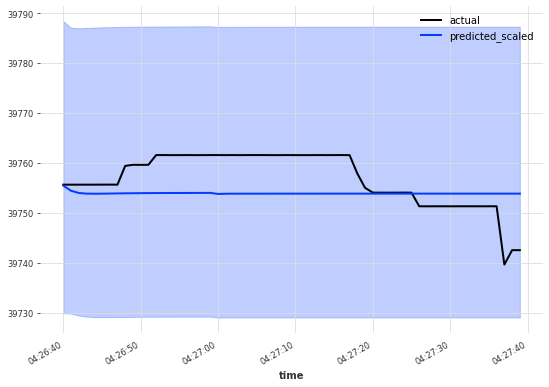

In [30]:
plt.figure(figsize=figsize)
#val set
val[:60].plot(label="actual")
#preds
pred_series_scaled.plot(label="predicted_scaled")

In [ ]:
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
print('Execution time:', str(timedelta(seconds=executionTime)))